# LetNet

LeNet is a series of convolutional neural network, it was one of the initial networks to become popular.

## 🛠️ Supported Hardware

This notebook can run in a CPU or in a GPU.

✅ AMD Instinct™ Accelerators  
✅ AMD Radeon™ RX/PRO Graphics Cards  
✅ AMD EPYC™ Processors  
✅ AMD Ryzen™ (AI) Processors  

Suggested hardware: **AI PC powered by AMD Ryzen™ AI Processors**

## ⚡ Recommended Software Environment

::::{tab-set}

:::{tab-item} Linux
- [Install Docker container](https://amdresearch.github.io/aup-ai-tutorials//env/env-gpu.html)
- [Install PyTorch](https://amdresearch.github.io/aup-ai-tutorials//env/env-cpu.html)
:::

:::{tab-item} Windows
- [Install Direct-ML](https://amdresearch.github.io/aup-ai-tutorials//env/env-gpu-windows.html)
- [Install PyTorch](https://amdresearch.github.io/aup-ai-tutorials//env/env-cpu.html)
:::
::::

## 🎯 Goals

- Show you how to download a model from PyTorch Hub
- Run LeNet a popular model on an AMD platform
- Evaluate the output probabilities and get the top 5 values

:::{seealso}
- [Torch Vision Models and pre-trained weights](https://pytorch.org/vision/0.20/models.html#classification)
- [Torch Vision GoogLeNet](https://pytorch.org/vision/0.20/models/googlenet.html)
- [LetNet Torch Hub](https://pytorch.org/hub/pytorch_vision_googlenet/)
- [LeNet Wikipedia](https://en.wikipedia.org/wiki/LeNet)
- [Convolutional Neural Networks (LeNet)](https://d2l.ai/chapter_convolutional-neural-networks/lenet.html)
:::

## 🚀 Run LeNet on an AMD Platform

Import the necessary packages

In [1]:
import torch
import urllib
import requests
from PIL import Image
from torchvision import transforms
import os
from torchvision.models import googlenet, GoogLeNet_Weights

Download the model from the torch hub, the model is trained for the ImageNet dataset

In [2]:
model = googlenet(weights=GoogLeNet_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /ROCM_APP/models/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████████████████████████████████████████████████████████████████████████████████████████| 49.7M/49.7M [00:00<00:00, 75.8MB/s]


Download a sample image from the PyTorch website and display it

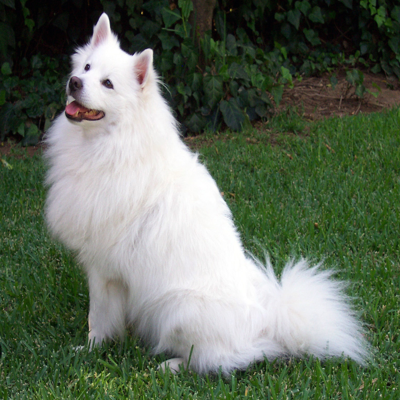

In [3]:
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "datasets/dog.jpg")
if not os.path.exists(filename):
    try:
        urllib.URLopener().retrieve(url, filename)
    except:
        urllib.request.urlretrieve(url, filename)
input_image = Image.open(filename)
input_image.resize((400, 400))

We are going to use `torchvision.transforms` to resize and normalize the image. Because we are using a single image, we will use `unsqueeze(0)` to create a batch of a single image

In [4]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)
print(f'{input_tensor.shape=} and {input_batch.shape=}')

input_tensor.shape=torch.Size([3, 224, 224]) and input_batch.shape=torch.Size([1, 3, 224, 224])


Check if GPU is available to be used, and move `model` and `input_batch` to the device

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'{device=}')

device=device(type='cuda')


In [6]:
input_batch = input_batch.to(device)
model.to(device);

Execute the inference inside the `torch.no_grad()` context not to track gradients. We also set the model to eval mode to disable layers such as `Dropout`
What we get as output is a tensor of shape 1,000, with confidence scores over ImageNet's 1000 classes.

In [7]:
model.eval()
with torch.no_grad():
    output = model(input_batch)

print(output[0][:32])

tensor([ 0.0356, -0.2288, -0.3233,  0.0555,  0.1136, -0.2825,  0.6154,  0.0610,
         0.9457, -1.4981, -0.5510, -0.0366, -1.2635, -0.0318,  0.5334,  0.1875,
         0.4931, -0.2829, -0.2720, -0.2618, -0.3316, -0.0757,  0.0671, -0.5709,
        -0.5318, -0.0500,  0.7216,  1.1626,  0.5152,  1.3022,  0.6907,  0.5568],
       device='cuda:0')


The output has unnormalized scores (logits). To get probabilities, you can run a softmax on it.

In [8]:
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print(probabilities[:32])

tensor([1.9209e-05, 1.4746e-05, 1.3417e-05, 1.9595e-05, 2.0768e-05, 1.3975e-05,
        3.4303e-05, 1.9702e-05, 4.7724e-05, 4.1441e-06, 1.0684e-05, 1.7871e-05,
        5.2396e-06, 1.7958e-05, 3.1600e-05, 2.2360e-05, 3.0352e-05, 1.3970e-05,
        1.4123e-05, 1.4267e-05, 1.3306e-05, 1.7185e-05, 1.9824e-05, 1.0474e-05,
        1.0892e-05, 1.7634e-05, 3.8145e-05, 5.9286e-05, 3.1031e-05, 6.8169e-05,
        3.6985e-05, 3.2348e-05], device='cuda:0')


Download the ImageNet labels

In [9]:
imagenet_classes = 'datasets/imagenet_classes.txt'
if not os.path.exists(imagenet_classes):
    with open(imagenet_classes, 'wb') as handler:
        handler.write(requests.get('https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt').content)

Read the categories for the downloaded file

In [10]:
with open(imagenet_classes, "r") as f:
    categories = [s.strip() for s in f.readlines()]

Show the top 5 categories inferred by the model from the image

In [11]:
top5_prob, top5_catid = torch.topk(probabilities, 5)
for prob, catidx in zip(top5_prob, top5_catid):
    print(f'{categories[catidx]}, {prob.item()*100:.2f}% probability')

Samoyed, 93.78% probability
Pomeranian, 0.83% probability
Great Pyrenees, 0.56% probability
Arctic fox, 0.55% probability
white wolf, 0.47% probability


----------
Copyright (C) 2025 Advanced Micro Devices, Inc. All rights reserved.

SPDX-License-Identifier: MIT